### Data from the r/memes subreddit

- 1000 posts per day, randomly dispersed throughout the day, on most days collection falls below this cap indicating we collected all available posts on that day
- scraped from Jan 1 2011 to present
- originally 955,152 memes were scraped, now we only include memes from 2018 on (899525)
- broken links and "image not found" results were removed
- the selftext column was removed because only 0.06% of the memes had selftext data and it appears posts with selftext are less likely to be memes
- the score is calculated as upvotes - downvotes, no values are below 0
- 1% of the over_18 column is True

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# data
memes_data = pd.read_json('./Data/Memes/memesfinal_processed.json')
memes_data = memes_data.loc[:, ~memes_data.columns.str.contains('^Unnamed')]
memes_data['date'] = memes_data.id.str[:10]
memes_data['date'] = pd.to_datetime(memes_data['date'])

# merge viral feature
viral = pd.read_json('./results/processed_features/viral_05.json')
memes_data = memes_data.merge(viral, on='id')

# add title len feature
memes_data['title_length'] = memes_data['title_raw'].str.len()

print(len(memes_data))
memes_data.head()

899525


,id,score,num_comments,over18,url,date,title_raw,ocr_raw,caption_raw,all_text,processed,stemmed,title_length
0,2021.02.15_288,211152,1642,False,https://i.redd.it/n4ildkpurph61.png,2021-02-15,Wait I didn't mean it like that,High schooler: I'd kill for\ncollege tuition\n...,a man with a hat and a beard standing in front...,Wait I didn't mean it like that - High schoole...,"[wait, didnt, mean, like, high, schooler, kill...","[wait, didnt, mean, like, high, schooler, kill...",31
1,2020.10.20_959,207206,811,False,https://i.redd.it/gsqgq6uwuau51.jpg,2020-10-20,Don't be mad,"@ renk. 5\n@ 1 Award\n\nI'm a dude, and | fuck...",a couple of white dogs standing next to each o...,Don't be mad - @ renk. 5\n@ 1 Award\n\nI'm a d...,"[dont, mad, renk, award, dude, fucking, hate, ...","[dont, mad, renk, award, dude, fuck, hate, peo...",12
2,2020.01.18_675,207066,1734,False,https://i.redd.it/eg4t9kvlplb41.jpg,2020-01-18,For real tho,...,a cartoon of a cat with a box on its back,For real tho - ...,"[real, tho, cartoon, cat, box, back]","[real, tho, cartoon, cat, box, back]",12
3,2020.06.09_755,187936,743,False,https://i.redd.it/1wniz8ionv351.jpg,2020-06-09,Right as rain after that,— :\nMy stomach hurts Bo i\n\n/@\nIt’s probabl...,a bunch of legos that are sitting on top of ea...,Right as rain after that - — :\nMy stomach hur...,"[right, rain, stomach, hurt, it’s, probably, g...","[right, rain, stomach, hurt, it’, probabl, gho...",24
4,2020.07.08_336,182056,616,False,https://i.redd.it/nrj9smsfek951.jpg,2020-07-08,Licensed Dad Joke,Dads telling jokes at home\n\nDads cling es a ...,a collage of pictures of a dog wearing a birth...,Licensed Dad Joke - Dads telling jokes at home...,"[licensed, dad, joke, dad, telling, joke, home...","[licens, dad, joke, dad, tell, joke, home, dad...",17


In [15]:
# spearman's correlation coefficient between comments and score
from scipy import stats

res = stats.spearmanr(memes_data['score'], memes_data['num_comments'])

res.statistic

0.6497879062468268

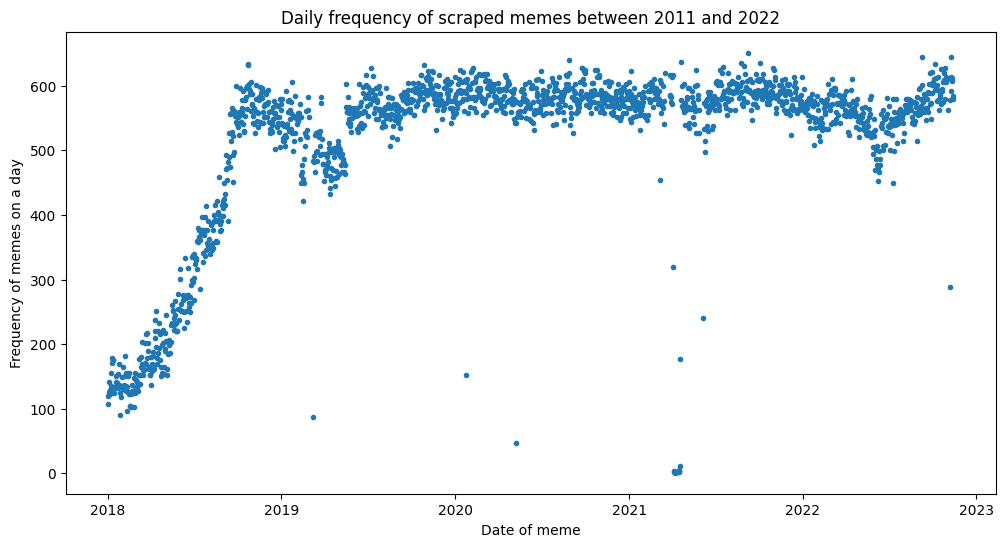

In [16]:
# distribution over time

memes_data['date'].dt.date.value_counts().plot(style='.',figsize=(12, 6))

plt.title('Daily frequency of scraped memes between 2011 and 2022')
plt.xlabel('Date of meme')
plt.ylabel('Frequency of memes on a day')
plt.show()

37


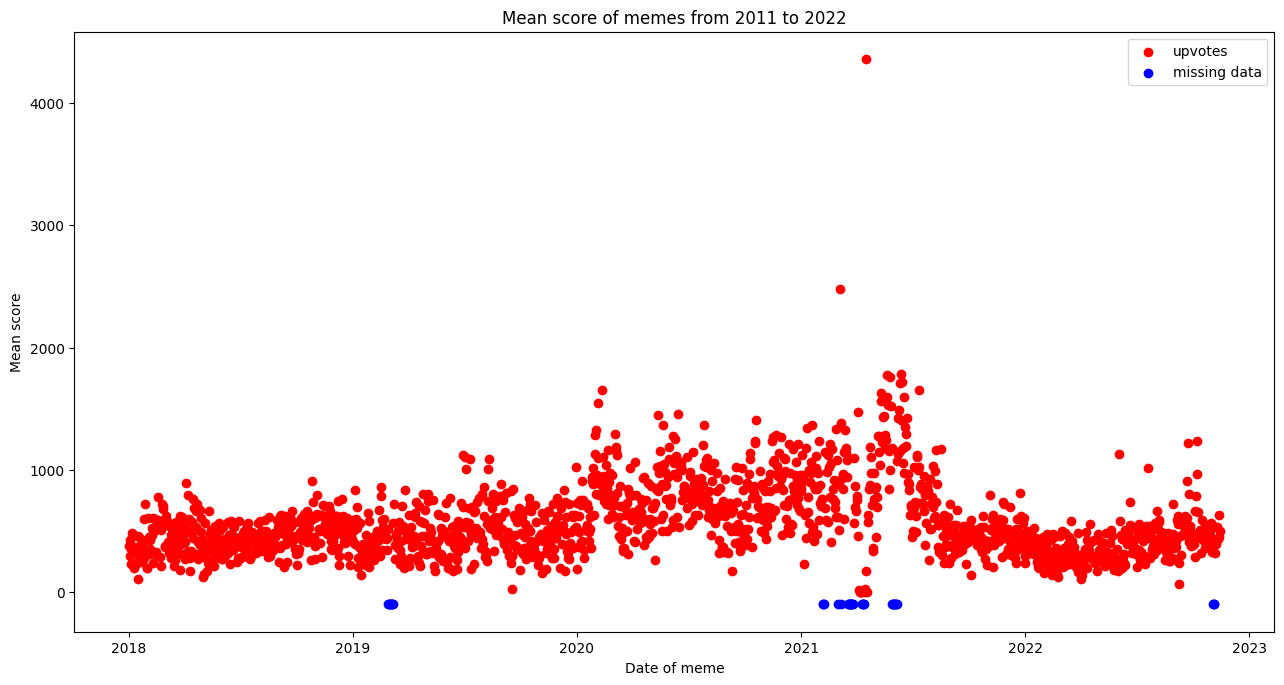

In [17]:
# visualize 37 missing dates due to API issues
grouped = memes_data.groupby(memes_data.date)
mean_score = grouped.score.mean()
mean_comments = grouped.num_comments.mean()
mean_title_len = grouped.title_length.mean()

# find missing dates
idx = pd.date_range(memes_data.date.min(), memes_data.date.max())
missing_dates = idx.difference(memes_data.date)
y = 100*np.negative(np.ones(len(missing_dates)))

fig=plt.figure(figsize =(12, 6))
ax=fig.add_axes([0,0,1,1])
ax.scatter(grouped.groups.keys(), mean_score, color='r')
ax.scatter(missing_dates, y,  color='b')
print(len(missing_dates))

plt.title('Mean score of memes from 2011 to 2022')
plt.xlabel('Date of meme')
plt.ylabel('Mean score')
plt.legend(['upvotes', 'missing data', 'no memes with score>100'])
plt.show()

In [8]:
# check if any other features show a systematic change by year  (UPVOTES, comments, len(title),source website e.g. external/internal links, over18)

for i in reversed(range(6)):
    print('{} memes have more than {} score, {:.2f}% of the dataset.'.format(sum(memes_data['score']>10**i),10**i,
                                                                    sum(memes_data['score']>10**i)/len(memes_data)*100))

183 memes have more than 100000 score, 0.01% of the dataset.
15475 memes have more than 10000 score, 0.91% of the dataset.
72352 memes have more than 1000 score, 4.27% of the dataset.
205501 memes have more than 100 score, 12.14% of the dataset.
869406 memes have more than 10 score, 51.34% of the dataset.
992091 memes have more than 1 score, 58.59% of the dataset.


In [9]:
for p in [0.99, 0.95, 0.9, 0.75]:
    print("The {:.0f}th percentile of the scores is at {:.0f}.".format(p*100,memes_data['score'].quantile(p)))

The 99th percentile of the scores is at 9159.
The 95th percentile of the scores is at 682.
The 90th percentile of the scores is at 136.
The 75th percentile of the scores is at 47.


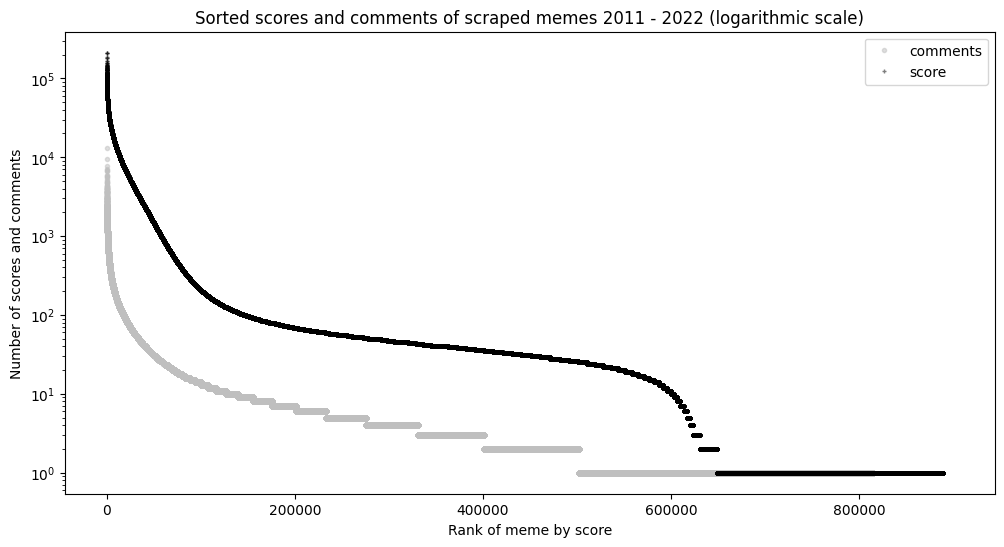

In [11]:
memes_data['num_comments'].sort_values(ascending=False).reset_index(drop=True).plot(style='o',color=[0.75,0.75,0.75,0.5],markersize=3,figsize=(12, 6))
memes_data['score'].sort_values(ascending=False).reset_index(drop=True).plot(style='+',color=[0,0,0,0.5],markersize=3,figsize=(12, 6))

plt.title('Sorted scores and comments of scraped memes 2011 - 2022 (logarithmic scale)')
plt.xlabel('Rank of meme by score')
plt.ylabel('Number of scores and comments')
plt.legend(['comments','score'])
plt.yscale('log')
plt.show()

In [26]:
import numpy as np

url_str = memes_data['url']
source_str = []

for i in range(0,len(memes_data)):
    temp = str(url_str[i])
    temp = str(temp[7:len(temp)])
    temp_binary = str(temp[len(temp)-4:len(temp)])
    source = temp[0:temp.find('/')]
    source_str.append(source)
    
memes_data['image_source'] = source_str 
print('top sites imags are sourced from: ')
pd.value_counts(np.array(memes_data['image_source'])).head(20)

top sites imags are sourced from: 


                              898757
imgur.com                        413
i.imgur.com                      218
cdn.ebaumsworld.com               95
i.redd.it                          9
www.greatestid.nl                  4
imgflip.com                        2
i0.kym-cdn.com                     2
4.bp.blogspot.com                  2
cdn.discordapp.com                 2
3.bp.blogspot.com                  1
static.pokemonpets.com             1
oi67.tinypic.com                   1
1.bp.blogspot.com                  1
beta.ems.ladbiblegroup.com         1
roshhashanna.com                   1
www.jar2.com                       1
sportsmockery.com                  1
screenrant.com                     1
cdn.acidcow.com                    1
dtype: int64

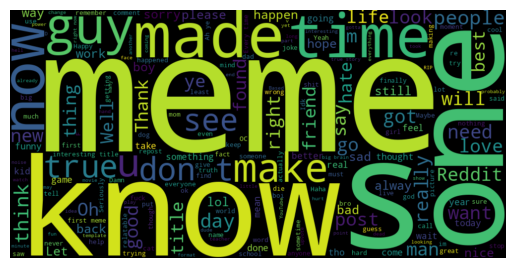

In [31]:
# wordcloud for meme text
# wordcloud for meme titles

from os import path
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# then draw the word cloud
to_wordcloud = " ".join(memes_data['title_raw'])
cloud = WordCloud(width =1000,height = 500).generate(to_wordcloud)
plt.imshow(cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

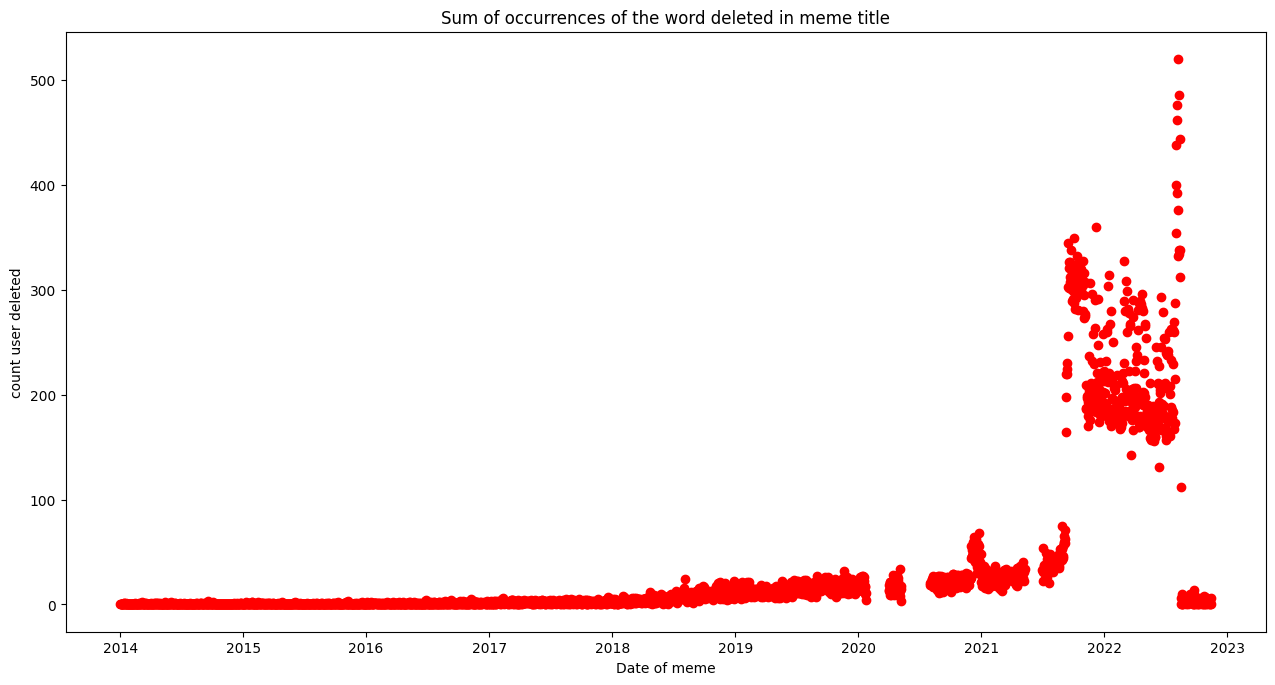

In [35]:
# plot distribution of user deleted titles 

memes_data['user_deleted'] = check
grouped = memes_data.groupby(memes_data.date)
mean_score = grouped.user_deleted.sum()

fig=plt.figure(figsize =(12, 6))
ax=fig.add_axes([0,0,1,1])
ax.scatter(grouped.groups.keys(), mean_score, color='r')
#memes_data['date'].dt.date.value_counts().plot(style='.', color='g')

plt.title('Sum of occurrences of the word deleted in meme title')
plt.xlabel('Date of meme')
plt.ylabel('count user deleted')
#plt.ylim( [100, 1500] )
plt.show()

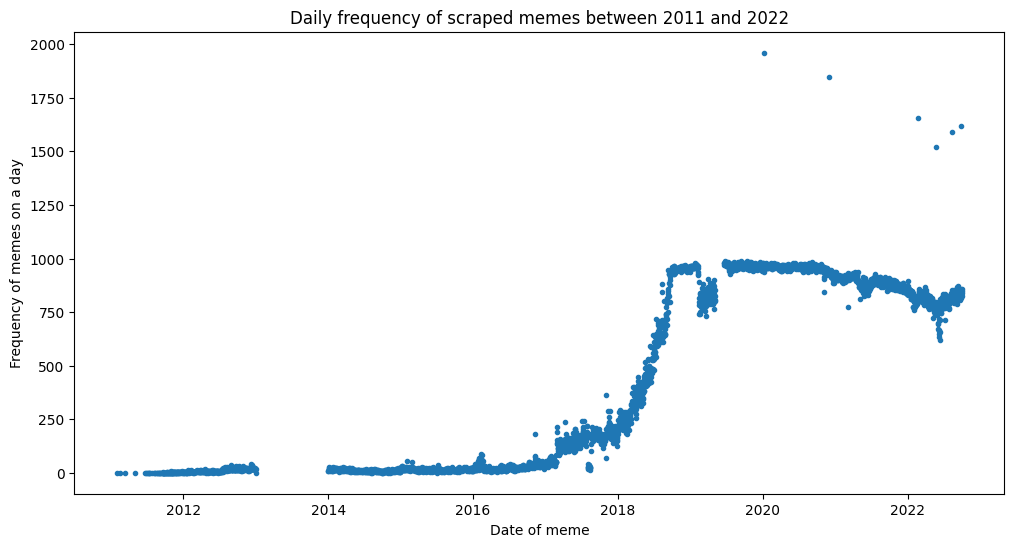

In [12]:
# distribution over time

memes_data['date'].dt.date.value_counts().plot(style='.',figsize=(12, 6))
plt.title('Daily frequency of scraped memes between 2011 and 2022')
plt.xlabel('Date of meme')
plt.ylabel('Frequency of memes on a day')
plt.show()